In [60]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

Load the dataset

In [61]:
ds1, ds2, ds3 = tfds.load('patch_camelyon:2.0.0',
                          split=['train[:10%]', 'test[:3%]', 'validation[:3%]'],
                          data_dir=r'/Users/emmahenneberggram/Documents/3. Semester/DS807 Anvendt Maskinlæring/Eksamen/',
                          download=False,
                          shuffle_files=True)

Konverterer en enkelt sample fra et datasæt til det format, der er nødvendigt for træning af en autoencoder.

In [62]:
def convert_sample(sample):
    image = sample['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, image  # Returner billedet som både input og label

Map and batch the datasets 

In [63]:
train_dataset       = ds1.map(convert_sample).batch(32)
validation_dataset  = ds3.map(convert_sample).batch(32)
test_dataset        = ds2.map(convert_sample).batch(32)

Autoencoder model

In [64]:
# Definer input-størrelsen
input_shape = (96, 96, 3)  # For PCam dataset
# Encoder
input_img = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

Forberede autoencoder modellen og summary af modellen

In [65]:
# Kompilér autoencoder-modellen
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Hvis du ønsker at se en oversigt over modellen, kan du tilføje:
autoencoder.summary()   # se output shape

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 64)        3692

Træning af autoencoder modellen med 10 epoch og earlystopping

In [66]:
from keras.callbacks import EarlyStopping

# Definer tidlig stopning
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Træn model med tidlig stopning
history = autoencoder.fit(
    train_dataset, 
    epochs=10,
    validation_data=validation_dataset,
    callbacks=[early_stopping]  # Tilføj tidlig stopning som en callback
)


Epoch 1/10
820/820 [==============================] - 690s 840ms/step - loss: 0.0161 - val_loss: 0.0126
Epoch 2/10
820/820 [==============================] - 1152s 1s/step - loss: 0.0106 - val_loss: 0.0116
Epoch 3/10
820/820 [==============================] - 1128s 1s/step - loss: 0.0092 - val_loss: 0.0090
Epoch 4/10
820/820 [==============================] - 1115s 1s/step - loss: 0.0084 - val_loss: 0.0083
Epoch 5/10
820/820 [==============================] - 1146s 1s/step - loss: 0.0078 - val_loss: 0.0080
Epoch 6/10
820/820 [==============================] - 1198s 1s/step - loss: 0.0074 - val_loss: 0.0074
Epoch 7/10
820/820 [==============================] - 1081s 1s/step - loss: 0.0070 - val_loss: 0.0070
Epoch 8/10
820/820 [==============================] - 1039s 1s/step - loss: 0.0067 - val_loss: 0.0067
Epoch 9/10
820/820 [==============================] - 871s 1s/step - loss: 0.0065 - val_loss: 0.0065
Epoch 10/10
820/820 [==============================] - 837s 1s/step - loss: 0.006

**Evaluering af Autoenkoderen**

Visualisering af Autoencoder Genopbygningsresultater med Matplotlib

1/1 [==============================] - 1s 640ms/step


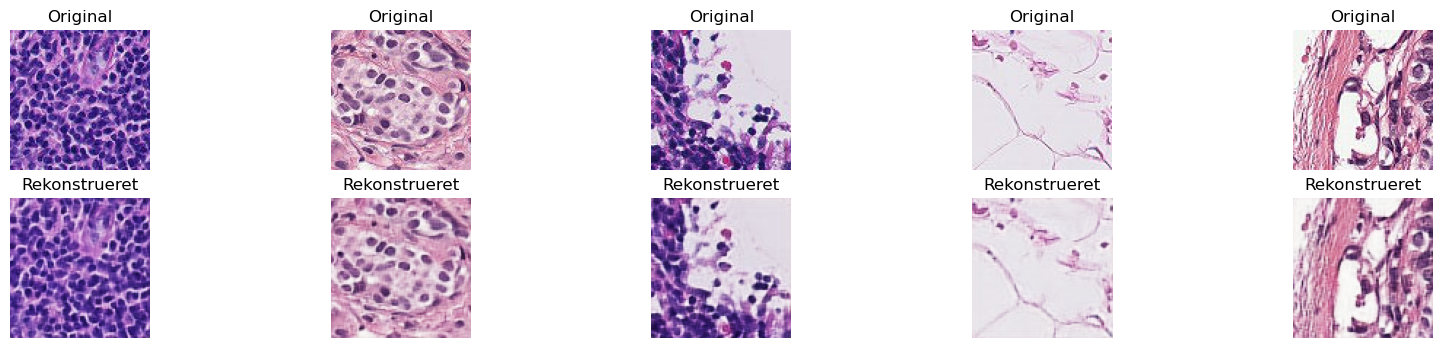

In [67]:
import matplotlib.pyplot as plt

def display_reconstructions(model, data, n_images=5):
    original_images = next(iter(data.take(1)))[0]  # Antager at data er et batch af billeder
    reconstructed_images = model.predict(original_images)

    plt.figure(figsize=(20, 4))
    for i in range(n_images):
        # Vis originalbillede
        ax = plt.subplot(2, n_images, i + 1)
        plt.imshow(original_images[i])
        plt.title("Original")
        plt.axis("off")

        # Vis rekonstrueret billede
        ax = plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(reconstructed_images[i])
        plt.title("Rekonstrueret")
        plt.axis("off")
    plt.show()

# Kald funktionen med din autoenkoder og et datasæt
display_reconstructions(autoencoder, test_dataset)

**Beregning af Tab (Loss):**

Beregn tabet på testdatasættet for at få en kvantitativ vurdering af, hvor godt autoenkoderen rekonstruerer.

In [85]:
test_loss = autoencoder.evaluate(test_dataset)
print("Test Loss (MSE):", test_loss)


31/31 [==============================] - 8s 232ms/step - loss: 0.0056
Test Loss (MSE): 0.005625052843242884


Visualisering af trænings- og valideringstab

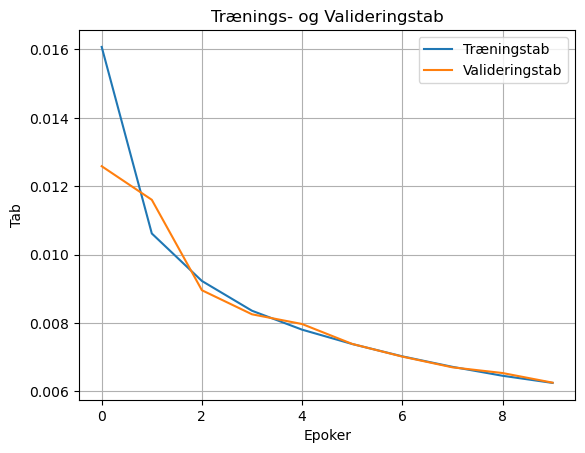

In [109]:
# Plot funktion for at visualisere trænings- og valideringstab
def plot_loss(history):
    plt.plot(history.history['loss'], label='Træningstab')
    plt.plot(history.history['val_loss'], label='Valideringstab')
    plt.title('Trænings- og Valideringstab')
    plt.xlabel('Epoker')
    plt.ylabel('Tab')
    plt.legend()
    plt.grid(True)
    plt.show()

# Kald plottefunktionen
plot_loss(history)

Forberedelse af datasæt til klassifikation

In [86]:
def prepare_classification_dataset(sample):
    image, label = sample['image'], sample['label']
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, depth=2)  # Da PCam er et binært klassifikationsproblem
    return image, label

Map og batch datasæt

In [87]:
train_dataset_cls = ds1.map(prepare_classification_dataset).batch(32)
validation_dataset_cls = ds3.map(prepare_classification_dataset).batch(32)
test_dataset_cls = ds2.map(prepare_classification_dataset).batch(32)

Skil data og labels ad

In [97]:
def extract_images_and_labels(dataset):
    images, labels = [], []
    for image_batch, label_batch in dataset:
        images.append(image_batch)
        labels.append(label_batch)
    return tf.concat(images, axis=0), tf.concat(labels, axis=0)

x_train, y_train = extract_images_and_labels(train_dataset_cls)
x_val, y_val = extract_images_and_labels(validation_dataset_cls)
x_test, y_test = extract_images_and_labels(test_dataset_cls)

Opret klassifikationsmodel udfra encoderen i autoencoder

In [20]:
encoder_output = autoencoder.layers[-1].output  # Få output fra encoder-delen
x = Flatten()(encoder_output)
x = Dense(128, activation='relu')(x)
classification_output = Dense(2, activation='softmax')(x)  # Da PCam er et binært klassifikationsproblem

classification_model = Model(inputs=autoencoder.input, outputs=classification_output)
classification_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Træning klassifikationsmodellen med trænings- og valideringsdata

In [26]:
CNNmodel = classification_model.fit(
    x_train, y_train, 
    epochs=10, 
    batch_size=32, 
    validation_data=(x_val, y_val)
)

Epoch 1/10
820/820 [==============================] - 980s 1s/step - loss: 0.6577 - accuracy: 0.6203 - val_loss: 0.4948 - val_accuracy: 0.7803
Epoch 2/10
820/820 [==============================] - 869s 1s/step - loss: 0.4869 - accuracy: 0.7710 - val_loss: 0.4599 - val_accuracy: 0.7854
Epoch 3/10
820/820 [==============================] - 1032s 1s/step - loss: 0.4539 - accuracy: 0.7917 - val_loss: 0.4373 - val_accuracy: 0.7986
Epoch 4/10
820/820 [==============================] - 968s 1s/step - loss: 0.4392 - accuracy: 0.8021 - val_loss: 0.4417 - val_accuracy: 0.8087
Epoch 5/10
820/820 [==============================] - 931s 1s/step - loss: 0.4165 - accuracy: 0.8137 - val_loss: 0.4650 - val_accuracy: 0.7731
Epoch 6/10
820/820 [==============================] - 873s 1s/step - loss: 0.4028 - accuracy: 0.8187 - val_loss: 0.4151 - val_accuracy: 0.8240
Epoch 7/10
820/820 [==============================] - 915s 1s/step - loss: 0.3766 - accuracy: 0.8360 - val_loss: 0.3964 - val_accuracy: 0.826

**Evaluering af Klassifikationsmodellen**

Nøjagtigheds- og Tabshistorik:

Plot nøjagtighed og tab over trænings- og valideringsdatasættene.

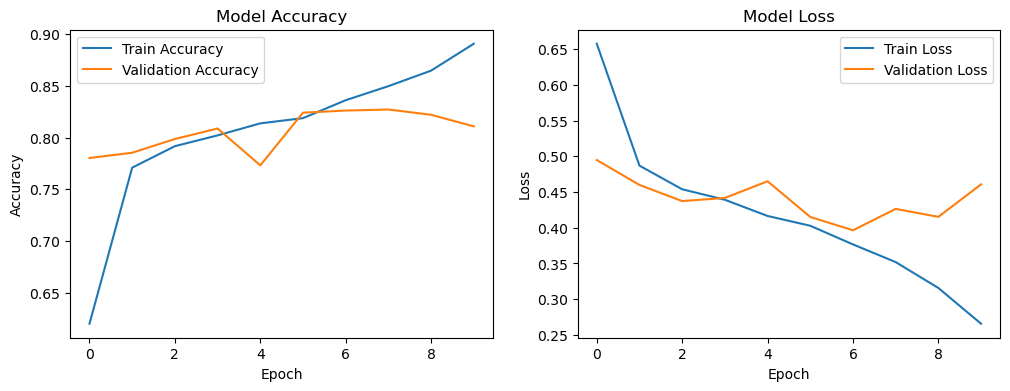

In [70]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot træningsnøjagtighed og valideringsnøjagtighed
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot træningstab og valideringstab
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Kald plot_history med træningshistorikken
plot_history(CNNmodel)


**Confusionsmatrix:**

En confusionsmatrix er en nyttig måde at se, hvordan vores model præsterer på tværs af forskellige klasser.

In [104]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

Plot af confusionmatrix på valiseringsdata

31/31 [==============================] - 6s 176ms/step


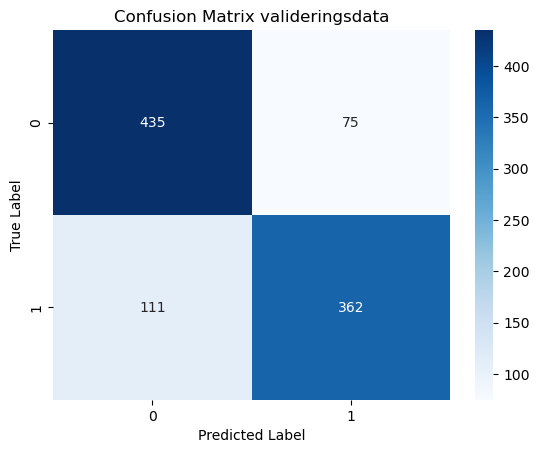

In [102]:
def plot_confusion_matrix(model, x_data, y_true):
    # Tjek at dataene er tensors, og kør .numpy() for at konvertere til numpy arrays
    if isinstance(y_true, tf.Tensor):
        y_true = y_true.numpy()
    if isinstance(x_data, tf.Tensor):
        x_data = x_data.numpy()

    y_pred = model.predict(x_data).argmax(axis=1)
    y_true_labels = y_true.argmax(axis=1)
    conf_mat = confusion_matrix(y_true_labels, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix valideringsdata')  # Tilføj overskrift her
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Forudsat at x_val og y_val allerede er indlæst som NumPy arrays eller TensorFlow tensors
plot_confusion_matrix(classification_model, x_val, y_val)

Plot af confusionmatrix på valiseringsdata

31/31 [==============================] - 6s 198ms/step


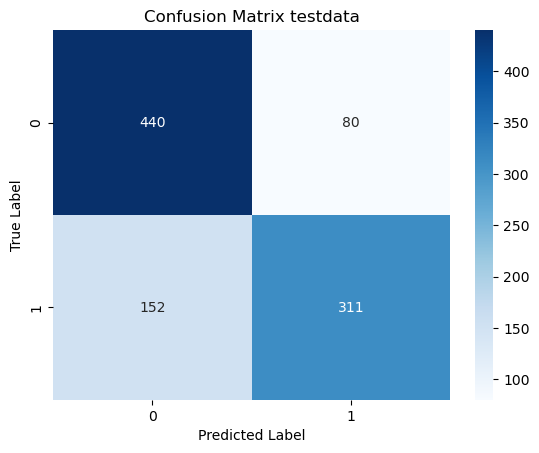

In [101]:
def plot_confusion_matrix(model, x_data, y_true):
    # Tjek at dataene er tensors, og kør .numpy() for at konvertere til numpy arrays
    if isinstance(y_true, tf.Tensor):
        y_true = y_true.numpy()
    if isinstance(x_data, tf.Tensor):
        x_data = x_data.numpy()

    y_pred = model.predict(x_data).argmax(axis=1)
    y_true_labels = y_true.argmax(axis=1)
    conf_mat = confusion_matrix(y_true_labels, y_pred)

    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix testdata')  # Tilføj overskrift her
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Anvend funktionen med testdata
plot_confusion_matrix(classification_model, x_test, y_test)

Undersøgelse af Datastørrelse og Labelinformation i Datasets

In [99]:
print("Træningssæt størrelse:", x_train.shape, y_train.shape)
print("Valideringssæt størrelse:", x_val.shape, y_val.shape)
print("Testsæt størrelse:", x_test.shape, y_test.shape)

print("Eksempel på træningslabel:", y_train[0])
print("Label datatype:", y_train.dtype)

Træningssæt størrelse: (26214, 96, 96, 3) (26214, 2)
Valideringssæt størrelse: (983, 96, 96, 3) (983, 2)
Testsæt størrelse: (983, 96, 96, 3) (983, 2)
Eksempel på træningslabel: tf.Tensor([1. 0.], shape=(2,), dtype=float32)
Label datatype: <dtype: 'float32'>


Evaluering af Modelydelse ved brug af ROC Kurve og AUC-værdi

31/31 [==============================] - 5s 172ms/step


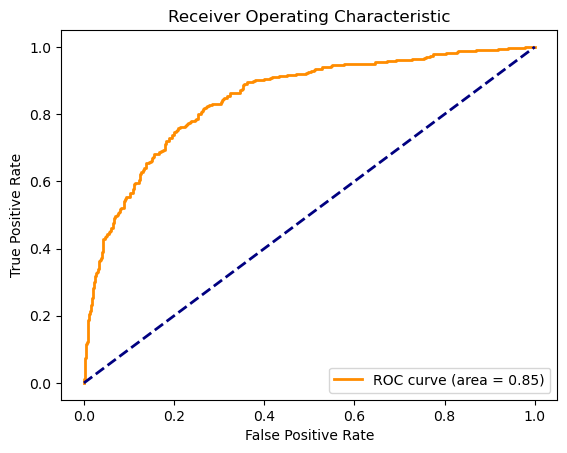

In [108]:
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import matplotlib.pyplot as plt

y_pred_prob = classification_model.predict(x_test)[:, 1]  # Forudsigelse af sandsynligheder for klasse 1

# Brug tf.argmax til TensorFlow tensors og konverter til numpy array
y_true = tf.argmax(y_test, axis=1).numpy()

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



Klassifikationsrapport for Model ydelse

In [107]:
from sklearn.metrics import classification_report
import tensorflow as tf

y_pred = classification_model.predict(x_test).argmax(axis=1)
y_true = tf.argmax(y_test, axis=1)  # Brug tf.argmax til TensorFlow tensors
y_true = y_true.numpy()  # Konverter til numpy array, hvis nødvendigt for sklearn funktioner

print(classification_report(y_true, y_pred))


 1/31 [..............................] - ETA: 10s

31/31 [==============================] - 6s 205ms/step
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       520
           1       0.80      0.67      0.73       463

    accuracy                           0.76       983
   macro avg       0.77      0.76      0.76       983
weighted avg       0.77      0.76      0.76       983

